# **[문제 3] 데이터 Feature 추가 후 성능 변화 확인하기**

- Regression, Classification 학습을 위한 데이터 관련 디폴트 설정 값은 문제 2와 동일하게 유지
  - sequence_size=15, validation_size=150, test_size=30, is_regression=False

- 데이터 Feature에 Next_Open 추가
  - Next_Open: 해당 일자 그 다음 날의 Open 가격

- [문제2] 에서 본인이 찾은 모델 구성 및 하이퍼파라미터 값을 그대로 사용

- 데이터 Feature에 Next_Open 을 추가하지 않았을 때와 추가하였을 때의 학습 성능 (Train 및 Validation 성능) 비교 및 테스트 (Test) 성능 비교
  - Regression 성능과 Classification 성능을 나누어 비교 결과 제시
  - 각각의 wandb 내 그래프들 모두 스크린샷을 얻어서 colab에 넣어 제시
  - Regression 테스트 성능 비교시에는 predict_all 함수 수행 결과 그래프를 각각 제시
  - 성능 비교 결과에 대해 자신의 해석을 비교적 자세하게 제시

## **0) Utility Code**

### **a_early_stopping**

In [ ]:
import os
import torch


class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss

### **b_strfdelta**

In [ ]:
from string import Template

class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)


def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )

### **c_regression_trainer**

In [ ]:
from datetime import datetime
import torch
from torch import nn


class RegressionTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.MSELoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train.squeeze(dim=-1), target_train)

      loss_train += loss.item()

      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains

    return train_loss

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)

        loss_validation += self.loss_fn(output_validation.squeeze(dim=-1), target_validation).item()

        num_validations += 1

    validation_loss = loss_validation / num_validations

    return validation_loss

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 1000 * epoch / elapsed_time.microseconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"V_loss: {validation_loss:7.5f}, "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Validation loss": validation_loss,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


### **d_classification_trainer**

In [ ]:
from datetime import datetime
import torch
from torch import nn


class ClassificationTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.CrossEntropyLoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train, target_train)
      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=1)
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:7.5f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


## **1) Next_Open 데이터 추가**

### **a_crypto_currency_dataset**

In [ ]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import os
import torch
import pandas as pd
import numpy as np


class CryptoCurrencyDataset(Dataset):
  def __init__(self, X, y, is_regression=True):
    self.X = X
    self.y = y

    assert len(self.X) == len(self.y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str


def get_cryptocurrency_data(
    sequence_size=15, validation_size=150, test_size=30, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
  btc_krw_path = os.path.join("cryptocurrency", "BTC_KRW.csv")
  df = pd.read_csv(btc_krw_path)
  row_size = len(df)
  # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
  date_list = df['Date']

  df = df.drop(columns=['Date'])

  data_size = row_size - sequence_size
  train_size = data_size - (validation_size + test_size)
  #################################################################################################

  # Next Open 컬럼을 추가하고, 다음 날의 Open 값으로 채우기
  df['Next Open'] = df['Open'].shift(-1)

  row_cursor = 0

  X_train_list = []
  y_train_regression_list = []
  y_train_classification_list = []
  y_train_date = []
  for idx in range(0, train_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_train_list.append(torch.from_numpy(sequence_data))
    y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_train_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_train_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_train = torch.stack(X_train_list, dim=0).to(torch.float)
  y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
  y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

  m = X_train.mean(dim=0, keepdim=True)
  s = X_train.std(dim=0, unbiased=False, keepdim=True)
  X_train = (X_train - m) / s

  #################################################################################################

  X_validation_list = []
  y_validation_regression_list = []
  y_validation_classification_list = []
  y_validation_date = []
  for idx in range(row_cursor, row_cursor + validation_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_validation_list.append(torch.from_numpy(sequence_data))
    y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_validation_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_validation_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
  y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
  y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

  X_validation = (X_validation - m) / s
  #################################################################################################

  X_test_list = []
  y_test_regression_list = []
  y_test_classification_list = []
  y_test_date = []
  for idx in range(row_cursor, row_cursor + test_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_test_list.append(torch.from_numpy(sequence_data))
    y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_test_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_test_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_test = torch.stack(X_test_list, dim=0).to(torch.float)
  y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
  y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

  X_test = (X_test - m) / s

  if is_regression:
    return (
      X_train, X_validation, X_test,
      y_train_regression, y_validation_regression, y_test_regression,
      y_train_date, y_validation_date, y_test_date
    )
  else:
    return (
      X_train, X_validation, X_test,
      y_train_classification, y_validation_classification, y_test_classification,
      y_train_date, y_validation_date, y_test_date
    )

### **b_arg_parser**

In [ ]:
import argparse


def get_parser():
  parser = argparse.ArgumentParser()

  parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
  )

  parser.add_argument(
    "-b", "--batch_size", type=int, default=32, help="Batch size (int, default: 32)"
  )

  parser.add_argument(
    "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
  )

  parser.add_argument(
    "-r", "--learning_rate", type=float, default=1e-4, help="Learning rate (float, default: 1e-3)"
  )

  parser.add_argument(
    "-w", "--weight_decay", type=float, default=0.0001, help="Weight decay (float, default: 0.0001)"
  )

  parser.add_argument(
    "-v", "--validation_intervals", type=int, default=30,
    help="Number of training epochs between validations (int, default: 10)"
  )

  parser.add_argument(
    "-p", "--early_stop_patience", type=int, default=30,
    help="Number of early stop patience (int, default: 10)"
  )

  parser.add_argument(
    "-d", "--early_stop_delta", type=float, default=0.000001,
    help="Delta value of early stop (float, default: 0.000001)"
  )

  return parser

## 2) **CryptoCurrency Regression Train**

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
!pip install wandb
import wandb
!wandb login
from pathlib import Path

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
CURRENT_FILE_PATH = "/content"
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

In [ ]:
def get_btc_krw_data(sequence_size=15, validation_size=150, test_size=30, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader

In [ ]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm1 = nn.LSTM(input_size=n_input, hidden_size=300, num_layers=3, batch_first=True, dropout=0.05)
      self.layer_norm = nn.LayerNorm(300)
      self.lstm2 = nn.LSTM(input_size=300, hidden_size=300, num_layers=3, batch_first=True, dropout=0.05)
      self.fcn = nn.Sequential(
          nn.Linear(in_features=300, out_features=64),
          nn.Dropout(0.25),
          nn.Linear(in_features=64, out_features=8),
          nn.ReLU(),
          nn.Linear(in_features=8, out_features=n_output),
      )

    def forward(self, x):
      x, hidden = self.lstm1(x)
      x = self.layer_norm(x)
      x, hidden = self.lstm2(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=6, n_output=1)

  return my_model

In [ ]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=project_name + "_next_open_" + run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)
  wandb.watch(model)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

In [ ]:
if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args("")
  main(args)

wandb: Currently logged in as: noeyhesx. Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=32, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 32, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 3.48454, V_loss: 0.06587, Early stopping is stated! | T_time: 00:00:01, T_speed: 0.001
[Epoch  30] T_loss: 0.05625, V_loss: 0.01539, V_loss decreased (0.06587 --> 0.01539). Saving model... | T_time: 00:00:31, T_speed: 0.035
[Epoch  60] T_loss: 0.05466, V_loss: 0.04098, Early stopping counter: 1 out of 30 | T_time: 00:01:02, T_speed: 0.520
[Epoch  90] T_loss: 0.05518, V_loss: 0.01431, V_loss decreased (0.01539 --> 0.01431). Saving model... | T_time: 00:01:31, T_speed: 0.189
[Epoch 120] T_loss: 0.06849, V_loss: 0.01047, V_loss decreased (0.01431 --> 0.01047). Saving model... | T_time: 00:02:00, T_speed: 0.139
[Epo

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▆▁▂▁▁▂▁▃▄█▁▅▂▁▂▁▁
Validation loss,▂▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▄▂▄▃▃▃▄▆▃▅▃▄▅▃▅█▅▅▄▄▄
Epoch,1080
Training loss,0.0135
Training speed (epochs/sec.),1.08192
Validation loss,0.25428


## **3) Regression Test**

In [ ]:
from matplotlib import pyplot as plt
CURRENT_FILE_PATH = "/content"
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

In [ ]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 1.0e7

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))

In [ ]:
def predict_all(test_model):
  y_normalizer = 1.0e7

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

In [ ]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 36,525,270.94 <--> 38,448,660.37 (Loss:  1,923,389.43)
 1: 46,861,362.46 <--> 45,989,146.23 (Loss:    872,216.22)
 2: 38,543,679.71 <--> 38,394,472.60 (Loss:    149,207.12)
 3: 37,203,199.86 <--> 36,773,695.95 (Loss:    429,503.92)
 4: 37,624,351.98 <--> 37,306,556.70 (Loss:    317,795.28)
 5: 38,557,403.09 <--> 38,457,825.18 (Loss:     99,577.90)
 6: 37,461,283.21 <--> 37,168,867.59 (Loss:    292,415.62)
 7: 36,071,555.61 <--> 36,748,924.26 (Loss:    677,368.64)
 8: 36,008,870.60 <--> 36,106,524.47 (Loss:     97,653.87)
 9: 36,181,283.00 <--> 36,345,636.84 (Loss:    164,353.85)
10: 37,525,155.54 <--> 37,305,316.93 (Loss:    219,838.62)
11: 47,261,238.10 <--> 46,157,298.09 (Loss:  1,103,940.01)
12: 46,452,503.20 <--> 46,684,732.44 (Loss:    232,229.23)
13: 44,635,591.51 <--> 45,568,060.87 (Loss:    932,469.37)
14: 36,749,961.38 <--> 35,979,855.06 (Loss:    770,106.32)
15: 35,831,143.86 <--> 36

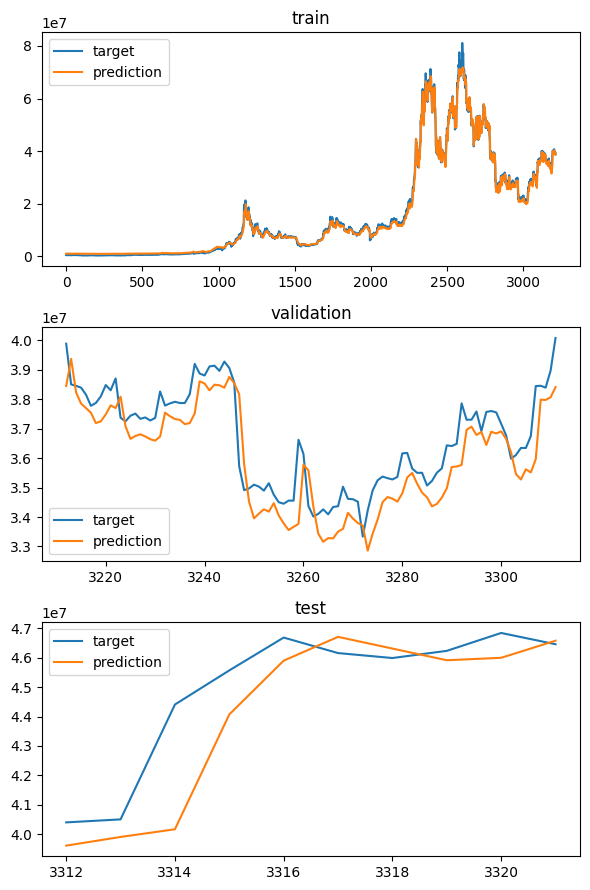

In [ ]:
if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args("")
  main(args)

## **🔥 데이터 Feature 추가 전 후, 결과 비교 (Regression)**

먼저, 모델이 저장된 시점의 `Validation Loss`는 `Next Open` Feature를 추가하기 전과 후에 큰 차이가 없었다.

하지만, 다음 Wandb 그래프를 확인해보면 최종적인 Loss로 도달하기까지, 데이터를 추가하기 전에는 `360 epoch` 가 걸렸고 데이터를 추가한 후에는 `180 epoch` 가 소요되었다.

<img src="https://github.com/BBOXEEEE/Deep_Learning/blob/main/_00_homework/hw4/img/regression_wandb.png?raw=true">

이를 통해 `Next Open` 데이터의 추가로 인해 학습 속도가 빨라졌다고 해석할 수 있다.

또한, Test 시에 나타난 다음의 그래프를 확인해보면 미세하지만 예측의 성능이 좋아졌다고 판단할 수 있다. Validation 시의 그래프가 좌상향된 모습을 볼 수 있는데 이는 데이터를 추가하기 전보다 조금 더 정확히 예측한다고 볼 수 있다.

<img src="https://github.com/BBOXEEEE/Deep_Learning/blob/main/_00_homework/hw4/img/regression_%EA%B2%B0%EA%B3%BC%EB%B9%84%EA%B5%90.png?raw=true">

## **4) CryptoCurrency Classification Train**

In [ ]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm1 = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
      self.layer_norm1 = nn.LayerNorm(normalized_shape=256, eps=1e-5)

      self.lstm2 = nn.LSTM(input_size=256, hidden_size=512, num_layers=3, batch_first=True)
      self.layer_norm2 = nn.LayerNorm(normalized_shape=512, eps=1e-5)

      self.lstm3 = nn.LSTM(input_size=512, hidden_size=256, num_layers=3, batch_first=True)
      self.layer_norm3 = nn.LayerNorm(normalized_shape=256, eps=1e-5)

      self.fcn = nn.Sequential(
          nn.Linear(in_features=256, out_features=128),
          nn.LayerNorm(128),
          nn.Dropout(p=0.25),
          nn.ReLU(),
          nn.Linear(in_features=128, out_features=n_output),
      )

    def forward(self, x):
      x, hidden = self.lstm1(x)
      x = self.layer_norm1(x)

      x, hidden = self.lstm2(x)
      x = self.layer_norm2(x)

      x, hidden = self.lstm3(x)
      x = self.layer_norm3(x)

      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model

In [ ]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)
  wandb.watch(model)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()

In [ ]:
if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args("")
  main(args)

Namespace(wandb=True, batch_size=32, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 32, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69460, T_accuracy: 49.7290 | V_loss: 0.69359, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69162, T_accuracy: 53.4906 | V_loss: 0.69490, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:28, T_speed: 1.071
[Epoch  60] T_loss: 0.69009, T_accuracy: 53.4906 | V_loss: 0.69645, V_accuracy: 47.3333 | Early stopping counter: 2 out of 30 | T_time: 00:00:57, T_speed: 1.053
[Epoch  90] T_loss: 0.68993, T_accuracy: 53.1718 | V_loss: 0.69398, V_accuracy: 47.3333 | Early stopping counter: 3 out of 30 | T_time: 00:01:26, T_speed: 1.047
[Epoc

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▇▇▇▆▆▇█▇█▆▇▆▇▇▇▇▇▇▇▆▇▇▇▇▇▆▇▇▇█▇▇▇▇▇▆▇▇▇
Training loss,█▄▂▃▂▃▂▂▄▄▃▂▃▄▃▃▂▄▂▁▄▂▁▂▄▂▂▁▂▁▂▃▂▄▄▂▁▄▁▂
Training speed (epochs/sec.),▁███████████████████████████████████████
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,▂▅▃▃▄▂▆▆▃▅▃▃▂▂▅▆▅▄▅▆▁▄▆▄▃▄▃▅▄▃▄▆▅▄▆▄█▄▃▃
Epoch,1830
Training accuracy (%),53.07619
Training loss,0.69028
Training speed (epochs/sec.),1.03157
Validation accuracy (%),47.33333


## **5) Classification Test**

In [ ]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))

In [ ]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)

In [ ]:
if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args("")
  main(args)

MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 63.333%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   0.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   0.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   0.00
 9:   1.00 <-->   0.00
10:   1.00 <-->   1.00
11:   1.00 <-->   0.00
12:   1.00 <-->   1.00
13:   1.00 <-->   1.00
14:   1.00 <-->   1.00
15:   1.00 <-->   0.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   1.00
19:   1.00 <-->   1.00
20:   1.00 <-->   1.00
21:   1.00 <-->   1.00
22:   1.00 <-->   0.00
23:   1.00 <-->   0.00
24:   1.00 <-->   1.00
25:   1.00 <-->   0.00
26:   1.00 <-->   1.00
27:   1.00 <-->   0.00
28:   1.00 <-->   1.00
29:   1.00 <-->   0.00


## **🔥 데이터 Feature 추가 전 후 결과 비교 (Classification)**

다음 Wandb 그래프를 비교해보았을 때, Next Open 데이터가 추가된 학습이 더 오래 걸린 것을 확인할 수 있다. 반면, Validation Loss는 조금 더 낮게 나오는 것을 확인할 수 있다.

<img src="https://github.com/BBOXEEEE/Deep_Learning/blob/main/_00_homework/hw4/img/classification_wandb.png?raw=true">

하지만, Classification에서는 두 방법의 차이가 크게 나타나지 않고 있다.


테스트 결과 정확도는 Next Open Feature 추가 전후 모두 `63.333%` 로 동일하게 나타났다.
약간의 성능 향상을 기대했는데 변화가 없었다는 점이 조금 아쉽다.

Regression 결과에서는 그래프 상에서 약간의 성능 향상이 보였지만, Classification 문제에서는 왜 이련 결과가 나타났는 지 고민해보았다.

결과를 분석하기 위해서 Regression 모델의 예측 그래프를 확인해 볼 필요가 있다. 대체적으로 특정 시점 늦은 결과를 예측한다.
즉, 모델의 예측이 실제 값과 비교했을 때 1~2일 정도 뒤의 값을 예측한다는 것이다. 같은 모델 구조를 사용해 학습했기 때문에 가격 상승을 0과 1로 분류하는 분류 모델은 더욱 성능이 낮을 것이라 판단된다.

예를 들어, 어제는 가격이 80, 오늘은 100, 내일은 70이다. 이때, 모델은 오늘을 80, 내일을 100으로 예측한다는 것이다. 이로 인해 모델의 예측이 성능이 낮다고 분석해볼 수 있을 것 같다.

# **🌈 숙제 후기 및 고찰**

딥러닝 마지막 과제가 끝이났다.

아마 이번 과제가 가장 생각한대로 흘러가지 않았던 것 같다.

먼저, Sequence Size와 기타 Default 설정을 과제 요구사항대로 변경하고 학습을 진행했을 때, 전반적으로 낮은 성능을 보인다는 것에서 1차로 당황을 했다. 분명 문제 1에서 80%까지 보여주던 성능이 63%대로 떨어진 것이 놀라웠다.

수업시간에 배웠던 여러 최적화 기법을 적용해보고, 모델을 조금 더 복잡하게 구성해봐도 큰 성능의 변화가 없었다는 점이 생각대로 진행되지 않은 포인트였다.

이전 과제에서 교재를 참고하고 구글링도 해보며 다른 사람들의 생각을 참고하고 나의 생각을 붙이다보면 조금씩 조금씩 성능이 향상되는 것이 보였었다. 하지만, 이번에는 무엇인가 마음대로 풀리지 않아 아쉽고 답답한 마음이 컸다.

나름대로 이것을 분석해본 결과, 우선 학습 데이터의 개수가 적었다는 점이다. 또한, Sequence의 길이가 늘어난다는 것은 기존 10일치의 데이터를 보고 다음 날의 종가를 예측하는 것과 15일치의 데이터를 보고 다음 날의 종가를 예측하는 차이가 생기는 것이다. 가격 변동이 불규칙적인 비트코인의 특성 상 Sequence의 길이가 늘어나면 모델이 학습해야 하는 난이도가 올라갈 것이라 나름대로 추측을 해본다.

한 학기동안 딥러닝 과목을 수강하고 과제를 하면서 정말 많은 것을 배웠다고 생각이 든다. 딥러닝에 더욱 관심이 생기는 계기가 되었고, 앞으로 더 깊이 있는 공부를 해보고 싶다는 생각이 드는 계기가 되었다.